# Bitcoin Trader Performance and Market Sentiment Analysis

### Objective
- explore the relationship between trader performance and market
sentiment, uncover hidden patterns, and deliver insights that can drive smarter trading
strategies.



In [1]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs -O historical_data.csv

Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/historical_data.csv
100% 47.5M/47.5M [00:00<00:00, 81.8MB/s]


In [2]:
!gdown https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf -O fear_greed_index.csv

Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed_index.csv
100% 90.8k/90.8k [00:00<00:00, 99.8MB/s]


### Loading Data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load historical data & sentiment data
historical_df = pd.read_csv("historical_data.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")

# Filter BTC trades ‚Äî adjust column name if needed (e.g., 'symbol' instead of 'Coin')
btc_df = historical_df[historical_df['Coin'].str.contains('BTC', case=False, na=False)]

print(f"Total BTC trades: {btc_df.shape[0]} (out of {historical_df.shape[0]} total trades)")


Total BTC trades: 26064 (out of 211224 total trades)


### Data Processing

In [4]:
# Convert Timestamp to datetime and extract date part
btc_df['date'] = pd.to_datetime(btc_df['Timestamp IST'], errors='coerce').dt.date

# Dropping columns not required for analysis from both datasets
btc_df.drop(['Coin', 'Direction', 'Transaction Hash', 'Order ID', 'Trade ID', 'Timestamp'], axis=1, inplace=True)
sentiment_df.drop(['timestamp','value'], axis=1, inplace=True)

/tmp/ipython-input-4-3233499924.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  btc_df['date'] = pd.to_datetime(btc_df['Timestamp IST'], errors='coerce').dt.date
/tmp/ipython-input-4-3233499924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_df['date'] = pd.to_datetime(btc_df['Timestamp IST'], errors='coerce').dt.date
/tmp/ipython-input-4-3233499924.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_df.drop(['Coin', 'Directio

Shape: (26064, 11)

Data Types & Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
Index: 26064 entries, 3001 to 209588
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Account          26064 non-null  object 
 1   Execution Price  26064 non-null  float64
 2   Size Tokens      26064 non-null  float64
 3   Size USD         26064 non-null  float64
 4   Side             26064 non-null  object 
 5   Timestamp IST    26064 non-null  object 
 6   Start Position   26064 non-null  float64
 7   Closed PnL       26064 non-null  float64
 8   Crossed          26064 non-null  bool   
 9   Fee              26064 non-null  float64
 10  date             26064 non-null  object 
dtypes: bool(1), float64(6), object(4)
memory usage: 2.2+ MB
None

Summary Statistics:
                                           Account  Execution Price  \
count                                        26064     26064.000000   
unique         

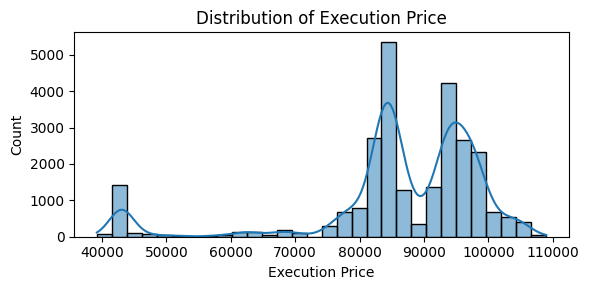

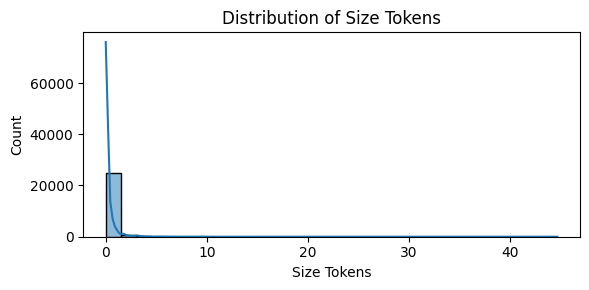

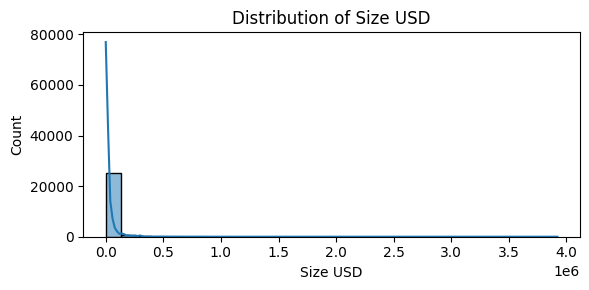

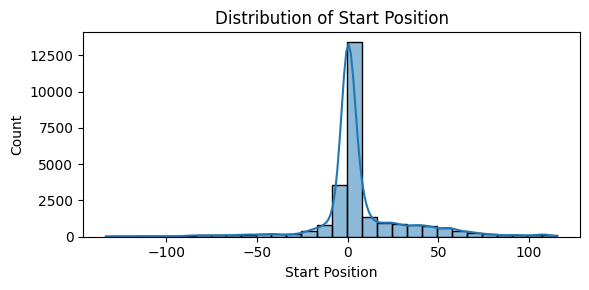

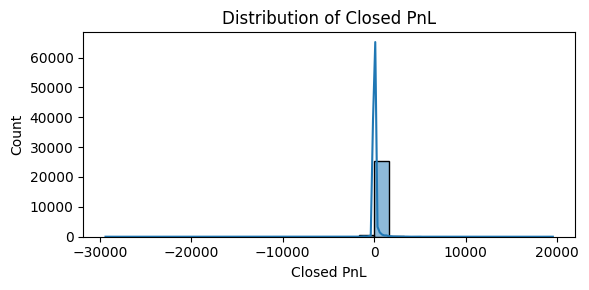

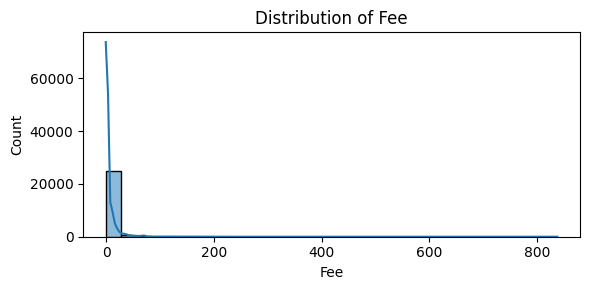

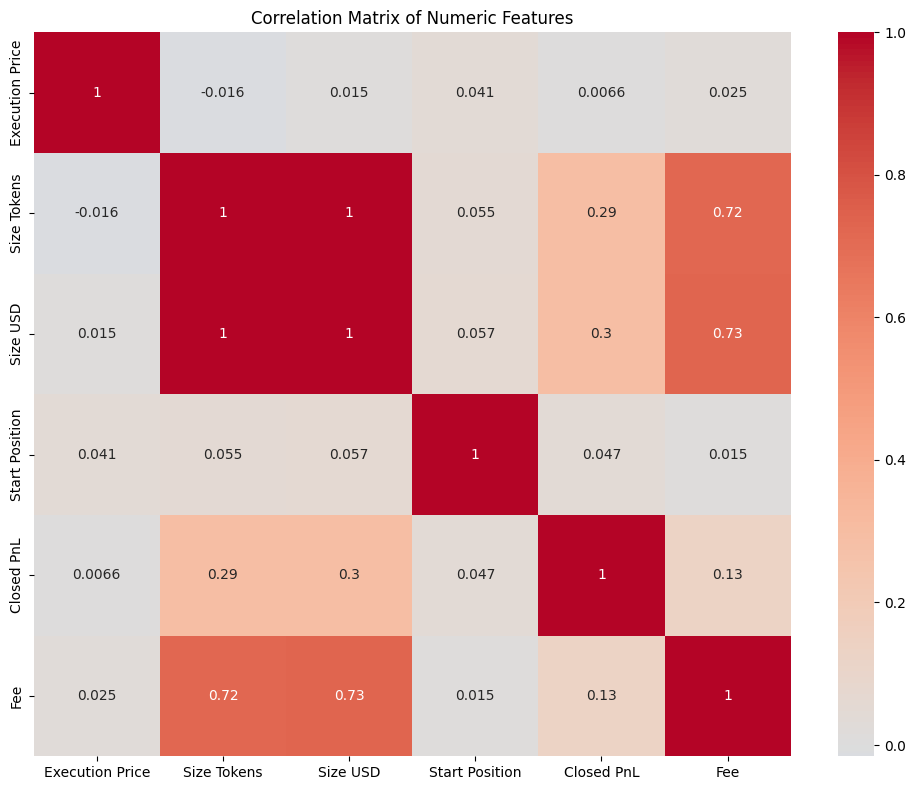

Size Tokens and Size USD show strong positive correlation with Fee (0.72 and 0.73), which makes sense as larger trades incur higher fees.


/tmp/ipython-input-5-493391831.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_df['date'] = pd.to_datetime(btc_df['date'], errors='coerce')


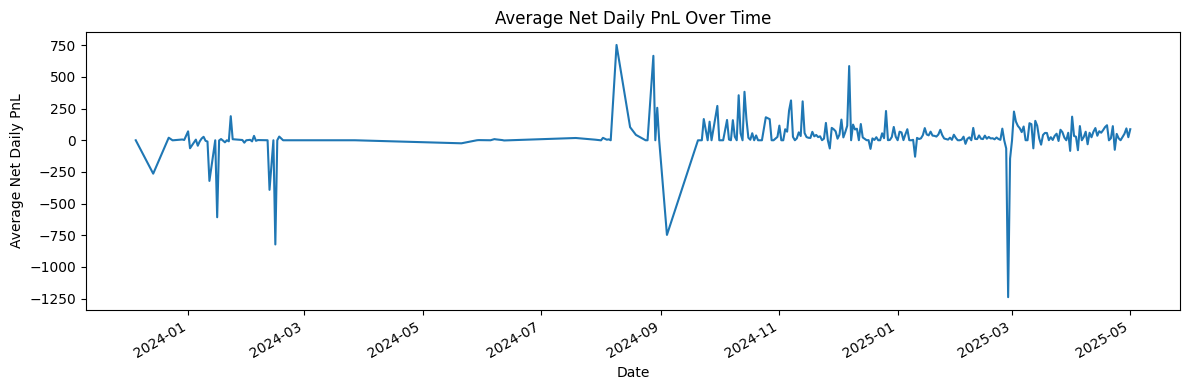

In [5]:
print(f"Shape: {btc_df.shape}")
print("\nData Types & Non-Null Counts:")
print(btc_df.info())
print("\nSummary Statistics:")
print(btc_df.describe(include='all'))

# ---------------------
# 3) Missing Values
# ---------------------
missing = btc_df.isnull().sum()
print("\nMissing Values:")
print(missing)


# ---------------------
# 4) Duplicates
# ---------------------
num_duplicates = btc_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")


# ---------------------
# 6) Feature Distributions
# ---------------------
numeric_cols = btc_df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(btc_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()



# ---------------------
# 8) Feature Correlation & Multicollinearity
# ---------------------
plt.figure(figsize=(10, 8))
corr_matrix = btc_df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

print("Size Tokens and Size USD show strong positive correlation with Fee (0.72 and 0.73), which makes sense as larger trades incur higher fees.")


# ---------------------
# 9) Time Dependencies
# ---------------------
if 'date' in btc_df.columns:
    btc_df['date'] = pd.to_datetime(btc_df['date'], errors='coerce')
    daily_pnl = btc_df.groupby('date')['Closed PnL'].mean()
    plt.figure(figsize=(12, 4))
    daily_pnl.plot()
    plt.title('Average Net Daily PnL Over Time')
    plt.ylabel('Average Net Daily PnL')
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()


In [6]:
btc_df.shape

(26064, 11)

In [7]:
print(f"Shape: {sentiment_df.shape}")
print("\nData Types & Non-Null Counts:")
print(sentiment_df.info())
print("\nSummary Statistics:")
print(sentiment_df.describe(include='all'))

# ---------------------
# 3) Missing Values
# ---------------------
missing = sentiment_df.isnull().sum()
print("\nMissing Values:")
print(missing)


# ---------------------
# 4) Duplicates
# ---------------------
num_duplicates = sentiment_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

Shape: (2644, 2)

Data Types & Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   classification  2644 non-null   object
 1   date            2644 non-null   object
dtypes: object(2)
memory usage: 41.4+ KB
None

Summary Statistics:
       classification        date
count            2644        2644
unique              5        2644
top              Fear  2025-05-02
freq              781           1

Missing Values:
classification    0
date              0
dtype: int64

Number of duplicate rows: 0


### Feature Engineering

In [8]:
agg_btc_df = (
    btc_df
    .groupby(['date', 'Account'])
    .agg(
        net_daily_pnl=('Closed PnL', 'sum'),
        total_volume=('Size USD', 'sum'),
        num_trades=('Execution Price', 'count'),
        avg_execution_price=('Execution Price', 'mean'),
        avg_fee=('Fee', 'mean'),
        avg_start_position=('Start Position', 'mean'),
        num_buy=('Side', lambda x: (x == 'BUY').sum()),
        num_sell=('Side', lambda x: (x == 'SELL').sum()),
        mean_crossed=('Crossed', 'mean')
    )
    .reset_index()
)

# Add directional bias feature
agg_btc_df['buy_ratio'] = agg_btc_df['num_buy'] / (agg_btc_df['num_buy'] + agg_btc_df['num_sell'])

agg_btc_df.sort_values(['Account', 'date'], inplace=True)
agg_btc_df['rolling_pnl_mean_3d'] = (
    agg_btc_df.groupby('Account')['net_daily_pnl']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)
agg_btc_df['rolling_pnl_std_3d'] = (
    agg_btc_df.groupby('Account')['net_daily_pnl']
    .transform(lambda x: x.rolling(window=3, min_periods=1).std().fillna(0))
)


In [9]:
# Convert sentiment date to datetime.date type
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')
# If classification needs cleaning, strip whitespaces
sentiment_df['classification'] = sentiment_df['classification'].str.strip()


### Merging Sentiment Data with Trader Data

In [10]:
combined_df = pd.merge(
    agg_btc_df,
    sentiment_df,
    on='date',
    how='inner'
)

print(f"Combined dataset shape: {combined_df.shape}")
print(combined_df.head())


Combined dataset shape: (667, 15)
        date                                     Account  net_daily_pnl  \
0 2025-04-23  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd       7.378000   
1 2025-04-09  0x271b280974205ca63b716753467d5a371de622ab       0.000000   
2 2025-04-10  0x271b280974205ca63b716753467d5a371de622ab   12553.300504   
3 2025-04-22  0x271b280974205ca63b716753467d5a371de622ab       0.000000   
4 2025-04-23  0x271b280974205ca63b716753467d5a371de622ab  -77441.642485   

   total_volume  num_trades  avg_execution_price    avg_fee  \
0       6905.80           9         93633.333333   0.076731   
1    1240299.19          25         82565.640000  16.669620   
2    6415595.90         234         82510.059829   9.078305   
3    2806157.22          81         90745.530864   9.977447   
4    7254667.82         295         92842.596610   6.705278   

   avg_start_position  num_buy  num_sell  mean_crossed  buy_ratio  \
0           -0.024134        3         6      0.000000   0.333333  

In [11]:
combined_df.to_csv("combined_btc_trader_sentiment.csv", index=False)
print("Combined dataset saved as combined_btc_trader_sentiment.csv")

Combined dataset saved as combined_btc_trader_sentiment.csv


In [12]:
df = pd.read_csv("combined_btc_trader_sentiment.csv")

print(df.head())
print(df['classification'].value_counts())

         date                                     Account  net_daily_pnl  \
0  2025-04-23  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd       7.378000   
1  2025-04-09  0x271b280974205ca63b716753467d5a371de622ab       0.000000   
2  2025-04-10  0x271b280974205ca63b716753467d5a371de622ab   12553.300504   
3  2025-04-22  0x271b280974205ca63b716753467d5a371de622ab       0.000000   
4  2025-04-23  0x271b280974205ca63b716753467d5a371de622ab  -77441.642485   

   total_volume  num_trades  avg_execution_price    avg_fee  \
0       6905.80           9         93633.333333   0.076731   
1    1240299.19          25         82565.640000  16.669620   
2    6415595.90         234         82510.059829   9.078305   
3    2806157.22          81         90745.530864   9.977447   
4    7254667.82         295         92842.596610   6.705278   

   avg_start_position  num_buy  num_sell  mean_crossed  buy_ratio  \
0           -0.024134        3         6      0.000000   0.333333   
1           -6.852937     

In [13]:
df.shape

(667, 15)

### Visualizing Trader Data features by sentiment

/tmp/ipython-input-14-28291274.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='classification', y='net_daily_pnl', palette='coolwarm')


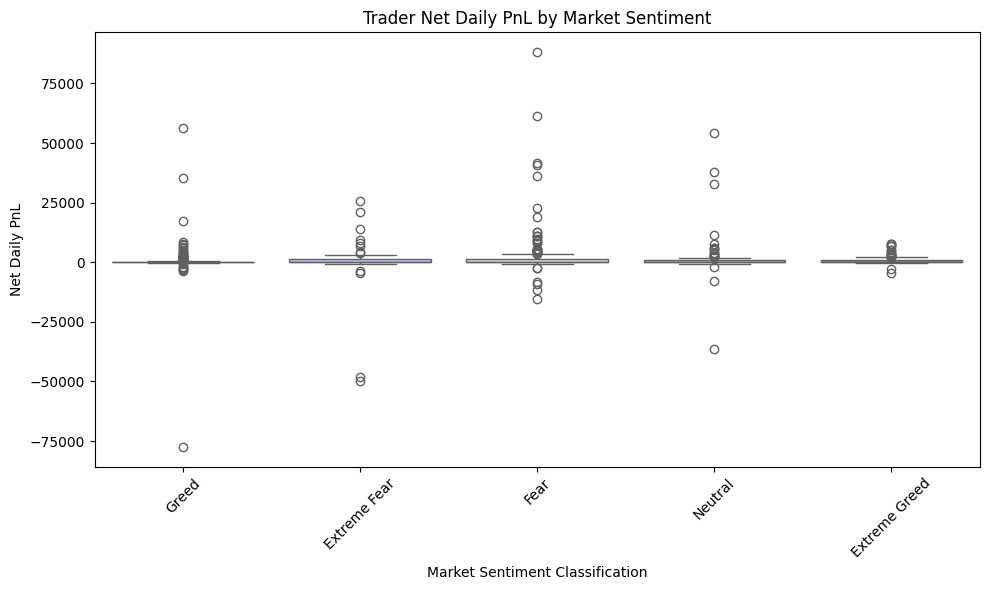

- Median Net PnL is relatively consistent across sentiments, but: Fear and Neutral conditions show greater variability and
more extreme outliers, suggesting traders may take higher risks or face more uncertainty in those market phases.


/tmp/ipython-input-14-28291274.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='classification', y='num_trades', palette='viridis')


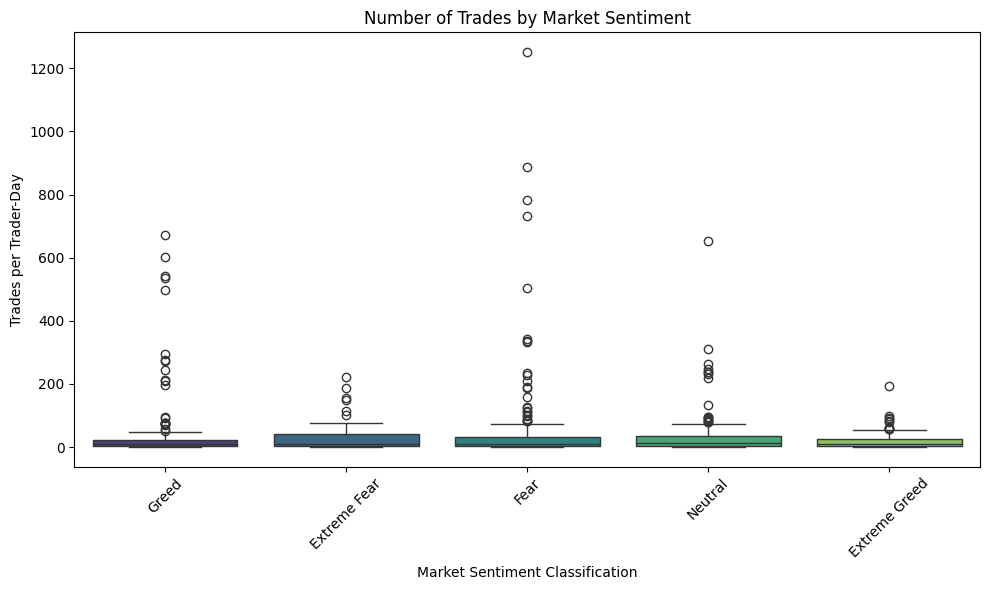

- Trade count is higher during Fear and Neutral sentiments, possibly indicating: Higher market activity or More
trading opportunities/risk-taking.Extreme Greed/Fear have lower average trades but contain notable outliers.


/tmp/ipython-input-14-28291274.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='classification', y='buy_ratio', palette='Set2')


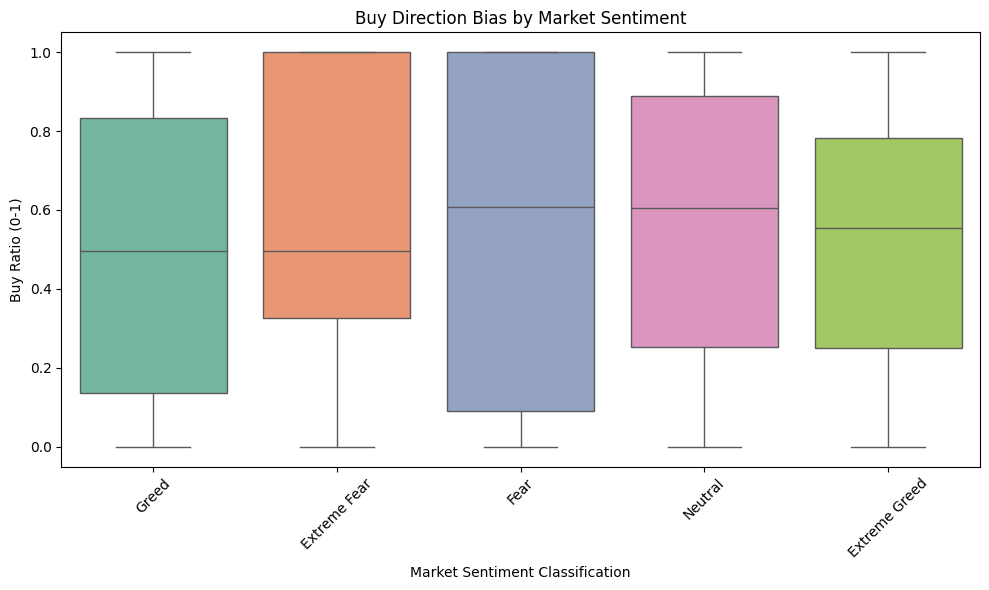

- Fear and Extreme Fear show a wider spread in buy ratio, indicating uncertainty or mixed strategy. In contrast,
Greed phases display a slightly more buy-heavy bias.Extreme sentiments show the broadest behavior variation.


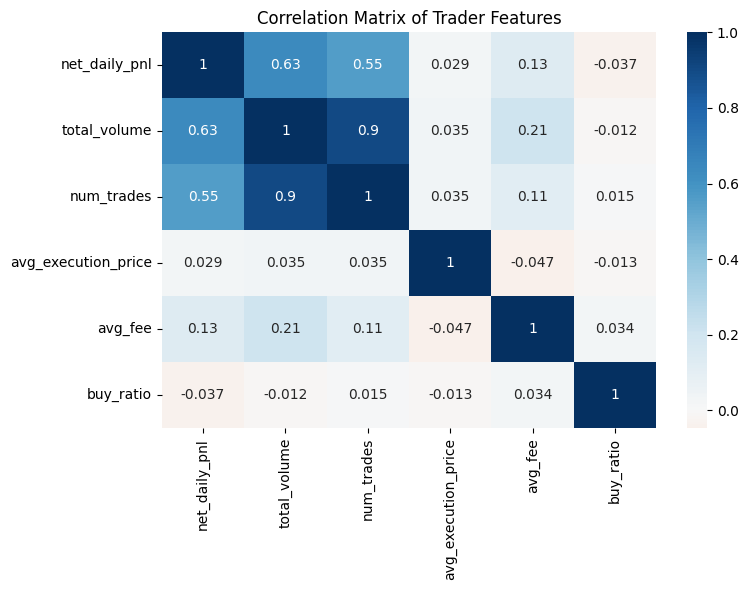

- Net Daily PnL positively correlates with: Total Volume (0.63) and Number of Trades (0.55), Buy Ratio has
no strong correlation with any feature ‚Äî indicating trade direction alone isn‚Äôt a key driver of PnL.


In [14]:
# PnL distribution by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='classification', y='net_daily_pnl', palette='coolwarm')
plt.title('Trader Net Daily PnL by Market Sentiment')
plt.ylabel('Net Daily PnL')
plt.xlabel('Market Sentiment Classification')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("- Median Net PnL is relatively consistent across sentiments, but: Fear and Neutral conditions show greater variability and")
print("more extreme outliers, suggesting traders may take higher risks or face more uncertainty in those market phases.")

# Number of trades by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='classification', y='num_trades', palette='viridis')
plt.title('Number of Trades by Market Sentiment')
plt.ylabel('Trades per Trader-Day')
plt.xlabel('Market Sentiment Classification')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("- Trade count is higher during Fear and Neutral sentiments, possibly indicating: Higher market activity or More")
print("trading opportunities/risk-taking.Extreme Greed/Fear have lower average trades but contain notable outliers.")

# Buy ratio by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='classification', y='buy_ratio', palette='Set2')
plt.title('Buy Direction Bias by Market Sentiment')
plt.ylabel('Buy Ratio (0-1)')
plt.xlabel('Market Sentiment Classification')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("- Fear and Extreme Fear show a wider spread in buy ratio, indicating uncertainty or mixed strategy. In contrast,")
print("Greed phases display a slightly more buy-heavy bias.Extreme sentiments show the broadest behavior variation.")

# Correlation heatmap
numeric_cols = ['net_daily_pnl', 'total_volume', 'num_trades', 'avg_execution_price', 'avg_fee', 'buy_ratio']
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0)
plt.title('Correlation Matrix of Trader Features')
plt.tight_layout()
plt.show()

print("- Net Daily PnL positively correlates with: Total Volume (0.63) and Number of Trades (0.55), Buy Ratio has")
print("no strong correlation with any feature ‚Äî indicating trade direction alone isn‚Äôt a key driver of PnL.")

In [15]:
df = pd.read_csv("combined_btc_trader_sentiment.csv")

print(df.head())
print(df['classification'].value_counts())

         date                                     Account  net_daily_pnl  \
0  2025-04-23  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd       7.378000   
1  2025-04-09  0x271b280974205ca63b716753467d5a371de622ab       0.000000   
2  2025-04-10  0x271b280974205ca63b716753467d5a371de622ab   12553.300504   
3  2025-04-22  0x271b280974205ca63b716753467d5a371de622ab       0.000000   
4  2025-04-23  0x271b280974205ca63b716753467d5a371de622ab  -77441.642485   

   total_volume  num_trades  avg_execution_price    avg_fee  \
0       6905.80           9         93633.333333   0.076731   
1    1240299.19          25         82565.640000  16.669620   
2    6415595.90         234         82510.059829   9.078305   
3    2806157.22          81         90745.530864   9.977447   
4    7254667.82         295         92842.596610   6.705278   

   avg_start_position  num_buy  num_sell  mean_crossed  buy_ratio  \
0           -0.024134        3         6      0.000000   0.333333   
1           -6.852937     

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 37.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 32.3% of the points cannot be plac

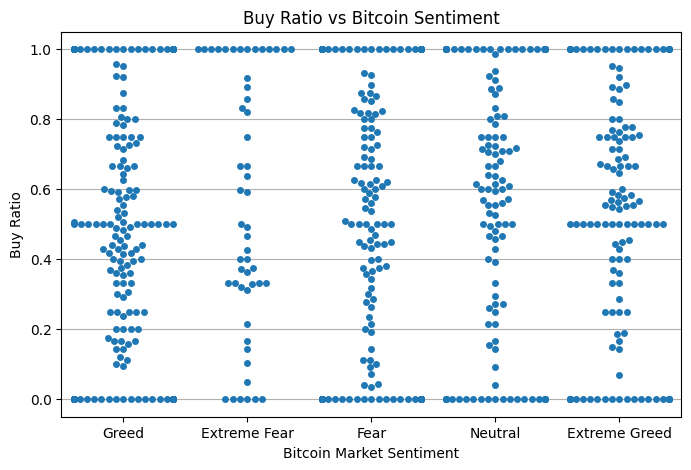

- Buy ratios are widely distributed across all sentiment classes. Traders don‚Äôt show a consistent
directional bias based on sentiment ‚Äî likely using more nuanced strategies.


In [16]:
# Buy Ratio vs Bitcoin Sentiment
plt.figure(figsize=(8, 5))
sns.swarmplot(data=df, x='classification', y='buy_ratio')
plt.title("Buy Ratio vs Bitcoin Sentiment")
plt.xlabel("Bitcoin Market Sentiment")
plt.ylabel("Buy Ratio")
plt.grid(True, axis='y')
plt.show()

print("- Buy ratios are widely distributed across all sentiment classes. Traders don‚Äôt show a consistent")
print("directional bias based on sentiment ‚Äî likely using more nuanced strategies.")


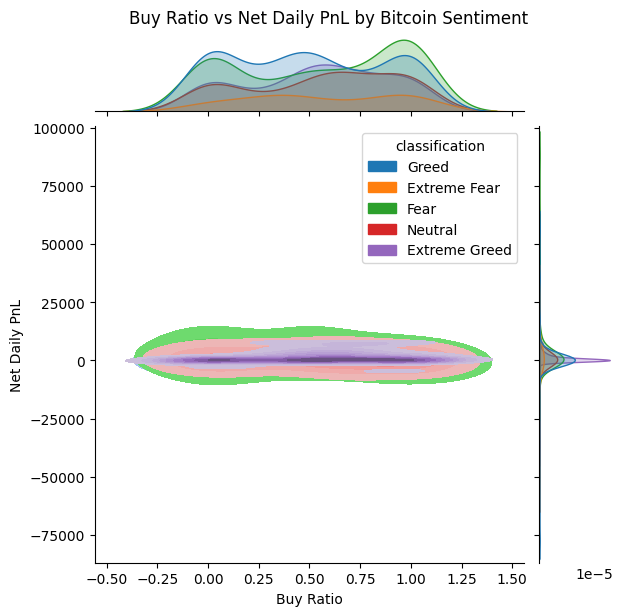

- There is no strong pattern indicating that buy ratio alone predicts PnL. Across all sentiment types,
PnL remains centered regardless of the buy ratio.Suggests PnL is driven by other factors like timing, volume, execution price, or market volatility.


In [17]:
sns.jointplot(
    data=df,
    x='buy_ratio',
    y='net_daily_pnl',
    hue='classification',
    kind='kde',
    fill=True,
    height=6
).set_axis_labels("Buy Ratio", "Net Daily PnL")
plt.suptitle("Buy Ratio vs Net Daily PnL by Bitcoin Sentiment", y=1.02)
plt.show()

print("- There is no strong pattern indicating that buy ratio alone predicts PnL. Across all sentiment types,")
print("PnL remains centered regardless of the buy ratio.Suggests PnL is driven by other factors like timing, volume, execution price, or market volatility.")

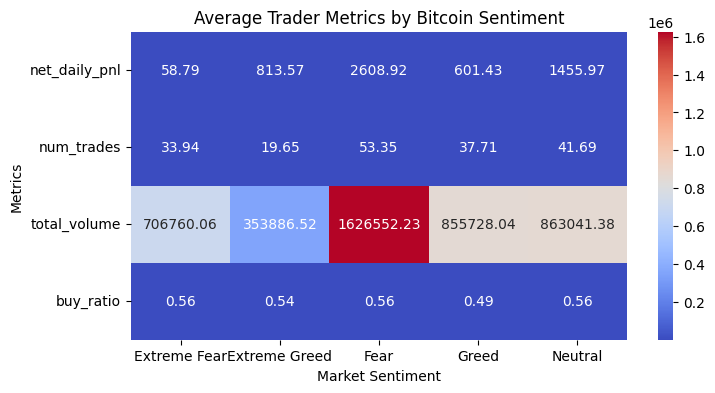

- Highest PnL and volume occur during Fear, indicating: Possibly profitable volatility. Lowest PnL and volume
is during Extreme Fear and Extreme Greed ‚Äî traders may be more cautious or face higher risk. Buy Ratio is mostly
consistent (0.49‚Äì0.56) across sentiments ‚Äî again showing directional neutrality.


In [18]:
# Average Trader Metrics by Bitcoin Sentiment Heatmap
summary_df = df.groupby('classification').agg({
    'net_daily_pnl': 'mean',
    'num_trades': 'mean',
    'total_volume': 'mean',
    'buy_ratio': 'mean'
}).T

plt.figure(figsize=(8, 4))
sns.heatmap(summary_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Average Trader Metrics by Bitcoin Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Metrics")
plt.show()

print("- Highest PnL and volume occur during Fear, indicating: Possibly profitable volatility. Lowest PnL and volume")
print("is during Extreme Fear and Extreme Greed ‚Äî traders may be more cautious or face higher risk. Buy Ratio is mostly")
print("consistent (0.49‚Äì0.56) across sentiments ‚Äî again showing directional neutrality.")

## Average Trader Metrics by Bitcoin Sentiment (Heatmap)

**Key Observations:**

* **net\_daily\_pnl** is highest during **Fear** (2608.92) and lowest in **Extreme Fear** (58.79), confirming traders occasionally profit big in Fear but massively lose in Extreme Fear.
* **num\_trades** peaks during Fear (53.35), indicating traders become most active under Fear.
* **total\_volume** is highest in Fear (1.62M), reflecting intense trading activity.
* **buy\_ratio** is relatively balanced (\~0.5-0.56) across sentiments, with slightly lower buy bias during Greed (0.49).

**Insights:**
‚úÖ Traders increase both **frequency and volume during Fear**, but net PnL is inconsistent and risky.
‚úÖ Extreme Fear leads to low net PnL despite moderate buy ratios ‚Äî implying frequent but unprofitable trades.

---

## üì¶ Number of Trades per Trade-Day by Market Sentiment (Boxplot)


**Key Observations:**

* Median trades/day are highest during **Fear**, with many outliers (some traders >1000 trades/day).
* Extreme Fear and Neutral have similar distributions, but fewer extreme outliers than Fear.
* Greed shows lower median and fewer large spikes in trade frequency.

**Insights:**
‚úÖ Fear sentiment **drives overtrading**, likely due to emotional responses to market drops.
‚úÖ Greed encourages **fewer but more deliberate trades**, possibly explaining why traders tend to perform better in Greed periods.

---

## üõí  Buy Direction Bias by Market Sentiment (Boxplot)


**Key Observations:**

* Buy ratio spreads are wide across all sentiments.
* Median buy ratios hover around 0.5 for all, but **Greed** has slightly lower median buy ratios ‚Äî indicating a relative tilt toward selling.
* Extreme Fear and Fear show high variance, with traders heavily polarized between buying and selling.

**Insights:**
‚úÖ Traders show **polarized directional biases during Fear/Extreme Fear**, with some aggressively buying dips and others panic-selling.
‚úÖ During Greed, slight **sell-side tilt** might indicate profit-taking behavior.



In [19]:
# Connecting Trader Behavior with Market Sentiment
df.sort_values('date', inplace=True)

# Compare avg PnL in Fear vs Greed
fear_pnl = df[df['classification'] == 'Fear']['net_daily_pnl'].mean()
extreme_fear_pnl = df[df['classification'] == 'Extreme Fear']['net_daily_pnl'].mean()
greed_pnl =df[df['classification'] == 'Greed']['net_daily_pnl'].mean()
extreme_greed_pnl =df[df['classification'] == 'Extreme Greed']['net_daily_pnl'].mean()
neutral_pnl = df[df['classification'] == 'Neutral']['net_daily_pnl'].mean()

print(f"Average PnL during Fear: {fear_pnl}, during Extreme Fear: {extreme_fear_pnl}, during Greed: {greed_pnl},")
print(f"during Extreme Greed: {extreme_greed_pnl}, during Neutral: {neutral_pnl}")


Average PnL during Fear: 2608.9169948972976, during Extreme Fear: 58.78539063461512, during Greed: 601.4332893177083,
during Extreme Greed: 813.57025075, during Neutral: 1455.967944096491


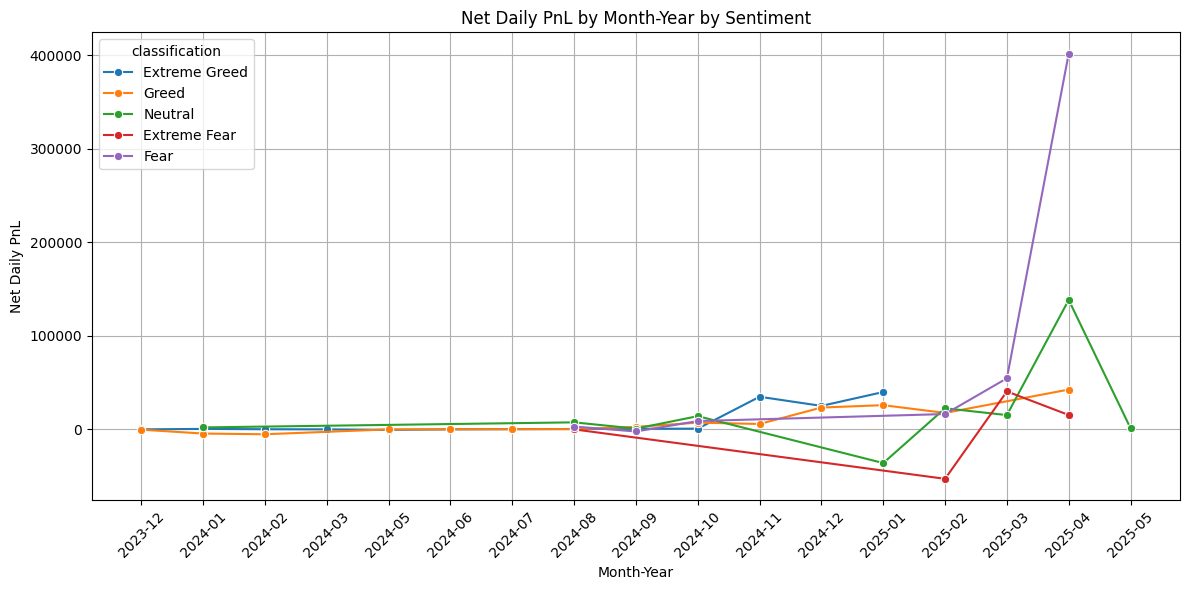

In [20]:
# üìà Net Daily PnL by Month-Year by Sentiment
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M').astype(str)

monthly_sentiment_pnl = df.groupby(['month_year', 'classification'])['net_daily_pnl'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sentiment_pnl, x='month_year', y='net_daily_pnl', hue='classification', marker='o')
plt.title('Net Daily PnL by Month-Year by Sentiment')
plt.xlabel('Month-Year')
plt.ylabel('Net Daily PnL')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### **Key Observations:**

* **Extreme PnL Volatility:**

  * There is a **massive spike in March 2025** in the **Fear** category, reaching a Net Daily PnL of around **‚Çπ400,000**.
  * Other months maintain relatively lower and stable PnL, except **April 2025 (Neutral)** which also shows a noticeable increase.

* **Fear vs Greed:**

  * **Fear sentiment** led to **both the highest gains** (March 2025) and **high fluctuations** overall.
  * **Greed and Extreme Greed** show moderate but steady gains over time.
  * **Extreme Fear** consistently shows **negative or low Net PnL**, especially in Jan‚ÄìFeb 2025.

### **Insights:**

* **Profits are not always tied to positive sentiment**: March 2025 shows that even during **Fear**, traders could realize **exceptional profits**, possibly due to high volatility.
* **Extreme Fear is risky**: Likely tied to losses or cautious trading behavior.
* **Steady growth during Greed periods**: Greed tends to produce **moderate, more stable returns**, which is useful for **risk-averse strategies**.


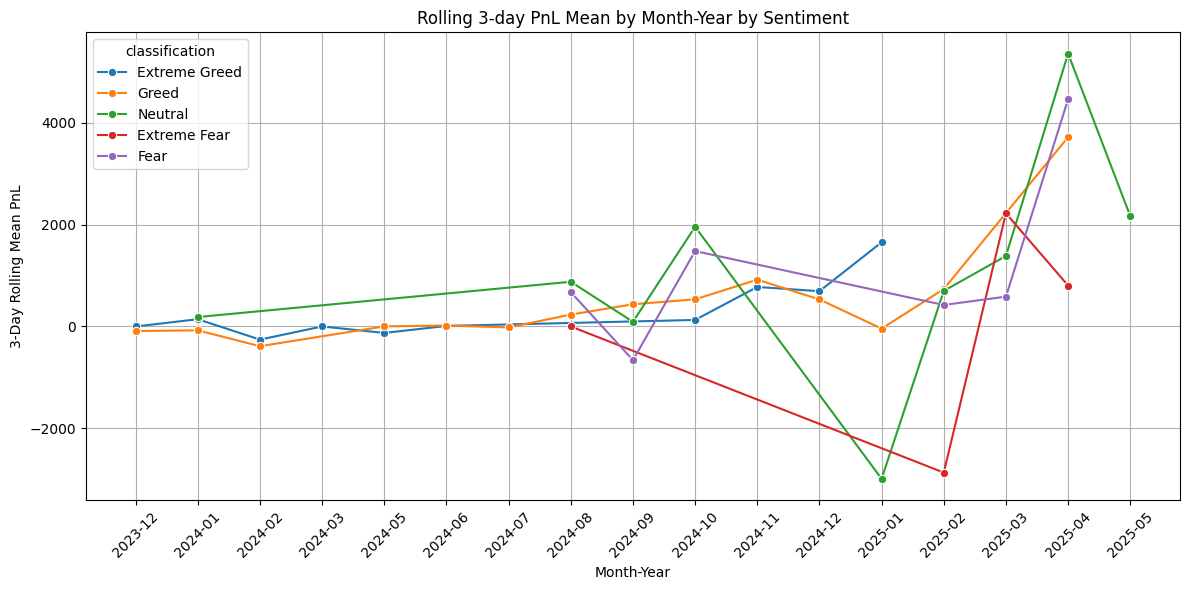

In [21]:
# üìà Rolling 3-day Mean of PnL by Month-Year by Sentiment
rolling_mean_df = df.groupby(['month_year', 'classification'])['rolling_pnl_mean_3d'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=rolling_mean_df, x='month_year', y='rolling_pnl_mean_3d', hue='classification', marker='o')
plt.title('Rolling 3-day PnL Mean by Month-Year by Sentiment')
plt.xlabel('Month-Year')
plt.ylabel('3-Day Rolling Mean PnL')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### **Key Observations:**

* **Smoother trends** due to the rolling average.
* **Neutral and Greed classifications** show a **consistent upward trend** post-August 2024.
* **Extreme Fear dips deeply** in late 2024 and early 2025, indicating persistent losses over consecutive days.
* **March‚ÄìApril 2025** again highlights **Fear and Greed** producing strong positive rolling averages.

### **Insights:**

* **Momentum strategies may benefit from Fear/Greed swings**: These rolling means suggest that **Fear periods can quickly transition into profitable streaks**.
* **Extreme Fear signals caution**: Frequent losses may occur when market panic is high.
* **Neutral periods are unpredictable**: Neutral sentiment led to both the highest gains (April 2025) and some fluctuations overall.

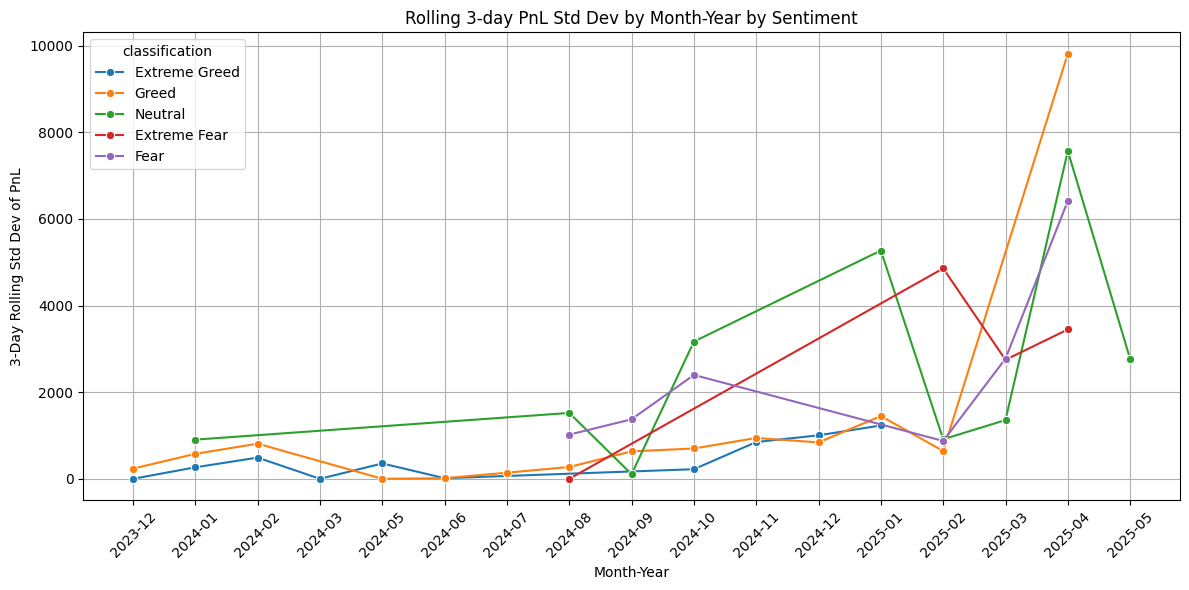

In [22]:
# üìà Rolling 3-day Std Dev of PnL by Month-Year by Sentiment
rolling_std_df = df.groupby(['month_year', 'classification'])['rolling_pnl_std_3d'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=rolling_std_df, x='month_year', y='rolling_pnl_std_3d', hue='classification', marker='o')
plt.title('Rolling 3-day PnL Std Dev by Month-Year by Sentiment')
plt.xlabel('Month-Year')
plt.ylabel('3-Day Rolling Std Dev of PnL')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


**Key Observations:**
* Volatility (measured by 3-day rolling standard deviation of trader PnL) spikes dramatically during **Fear and Greed periods**, especially from late 2024 into early 2025.
* **Neutral and Fear periods** had multiple large volatility surges, especially around 2025-03 to 2025-04.
* **Extreme Greed** periods showed lower volatility for most of the timeline.


**Insights:**
‚úÖ Fear phases are periods of **high unpredictability in trader performance**, where risk management is crucial.
‚úÖ Spikes in Greed volatility late in the period suggest **overconfidence leading to unstable performance**.



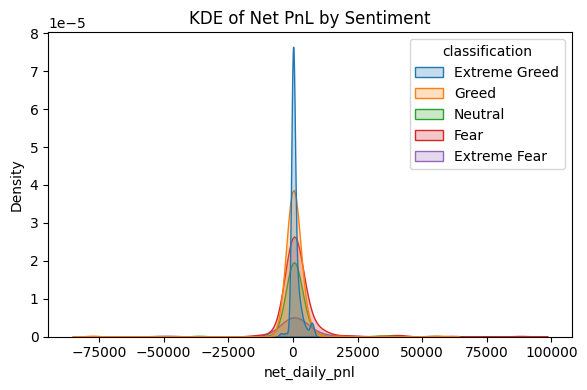

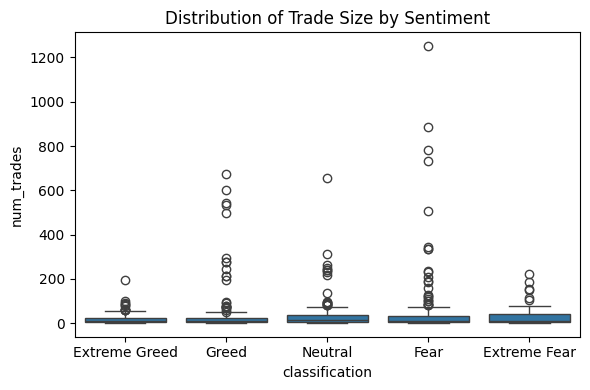

In [23]:
# KDE plot of Net PnL during Fear vs Greed
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df, x='net_daily_pnl', hue='classification', fill=True)
plt.title('KDE of Net PnL by Sentiment')
plt.tight_layout()
plt.show()

# Boxplot of number of trades during Fear vs Greed
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='classification', y='num_trades')
plt.title('Distribution of Trade Size by Sentiment')
plt.tight_layout()
plt.show()



### Encoding sentiment

In [24]:
sentiment_order = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}
df['sentiment_score'] = df['classification'].map(sentiment_order)


In [25]:
# Target variable
df['profitable'] = (df['net_daily_pnl'] > 0).astype(int)

In [26]:
# ---------------------
#  Target Distribution
# ---------------------
if 'profitable' in df.columns:
    sns.countplot(x='profitable', data=df)
    plt.title('Target Variable Distribution')
    plt.xlabel('Profitable (0=No, 1=Yes)')
    plt.show()

    print(df['profitable'].value_counts(normalize=True))


profitable
1    0.595202
0    0.404798
Name: proportion, dtype: float64


### Visualizing Feature-Target Relationships

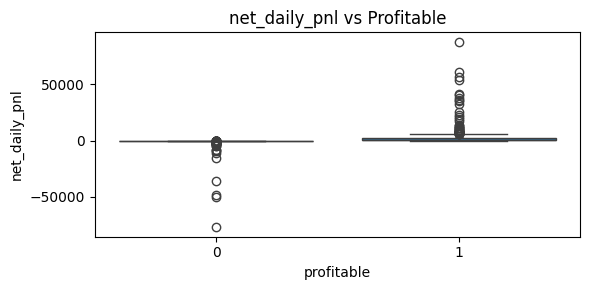

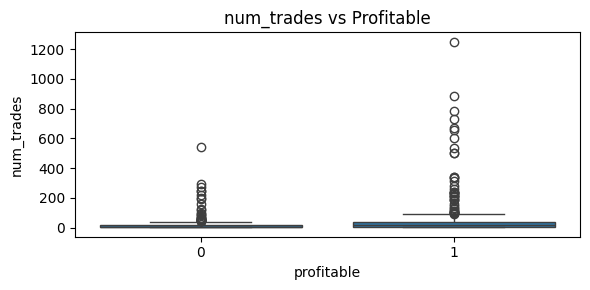

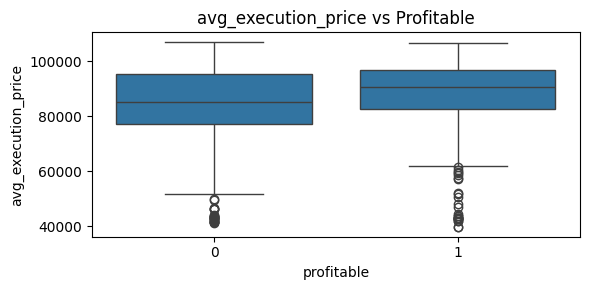

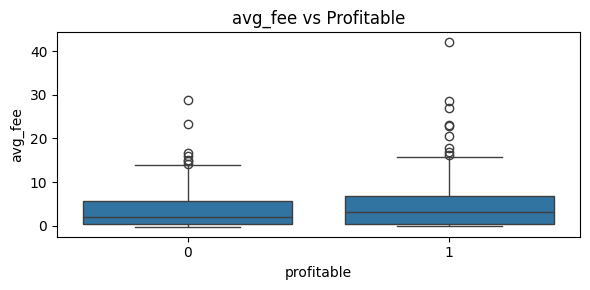

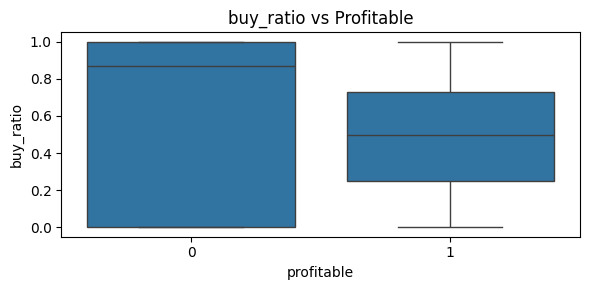

In [27]:
# ---------------------
#  Feature-Target Relationships
# ---------------------
if 'profitable' in df.columns:
    for col in numeric_cols:
        plt.figure(figsize=(6, 3))
        sns.boxplot(x='profitable', y=col, data=df)
        plt.title(f'{col} vs Profitable')
        plt.tight_layout()
        plt.show()



# net_daily_pnl vs Profitable


- Profitable trades (1) have a higher median and wider spread of daily PnL values.

- This suggests profitable traders not only win more often but also tend to win bigger.

# total_volume vs Profitable

- Profitable trades tend to have higher trading volumes.

- This might suggest that higher activity correlates with increased profitability ‚Äî potentially because active traders can better exploit market moves.

# num_trades vs Profitable


- Profitable traders typically execute more trades per day.

- Suggests trade frequency might positively influence profitability ‚Äî likely due to diversification across opportunities.



# buy_ratio vs Profitable

- Non-profitable outcomes heavily skew towards a high buy_ratio (~0.9‚Äì1) ‚Äî indicating those accounts predominantly bought but perhaps failed to time exits.

- Profitable traders exhibit a wider and more balanced distribution in buy_ratio, ranging from 0 to 1.

- Suggests successful traders balance between buying and selling, rather than over-committing to one side.

### Checking for Data leakage

In [28]:
# ---------------------
#  Data Leakage Check
# ---------------------
# Review high correlation with target; caution if feature seems "too predictive"!
numeric_cols = ['net_daily_pnl', 'total_volume', 'num_trades', 'avg_execution_price', 'avg_fee', 'buy_ratio', 'profitable']
if 'profitable' in df.columns:
    corr_with_target = df[numeric_cols].corr()['profitable'].sort_values(ascending=False)
    print("\nCorrelation of features with target 'profitable':")
    print(corr_with_target)



Correlation of features with target 'profitable':
profitable             1.000000
net_daily_pnl          0.251916
num_trades             0.144602
avg_execution_price    0.129402
total_volume           0.118201
avg_fee                0.067060
buy_ratio             -0.149345
Name: profitable, dtype: float64


### Visualizing Distribution of Features by Target (Profitability)

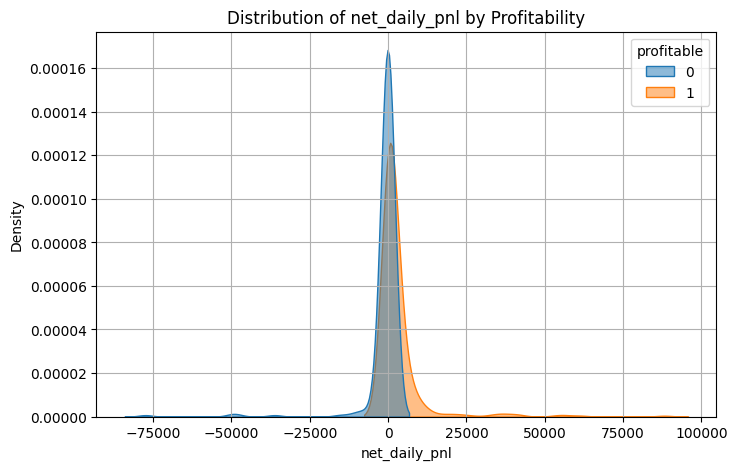

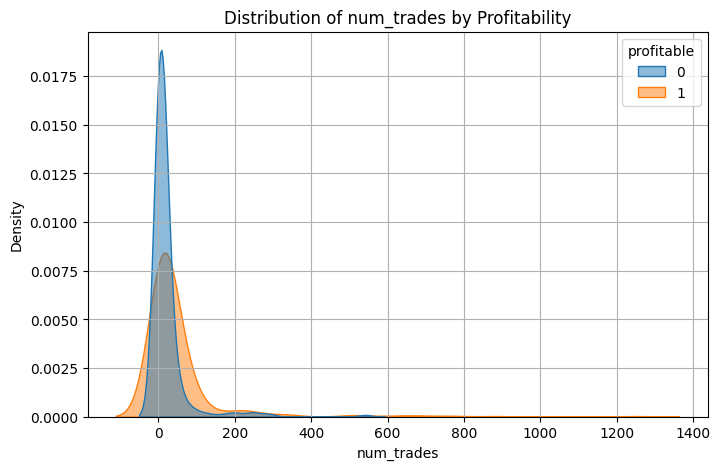

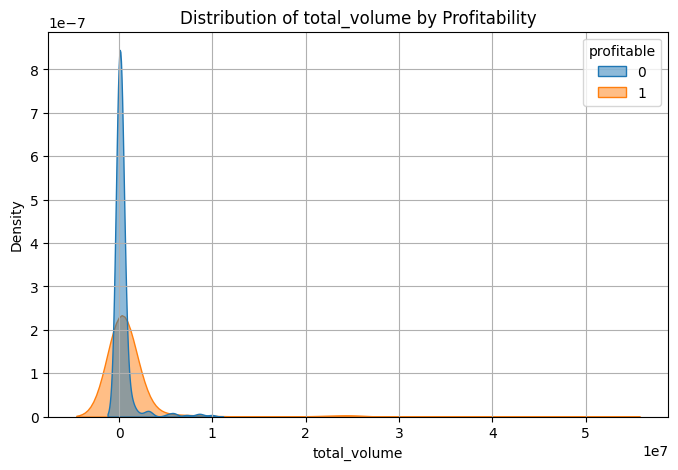

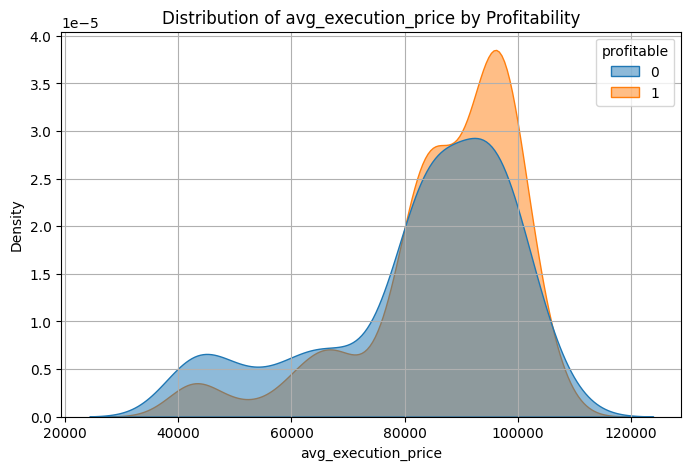

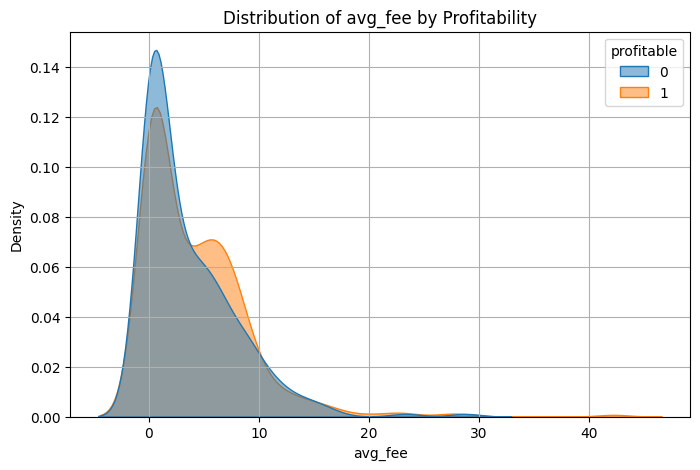

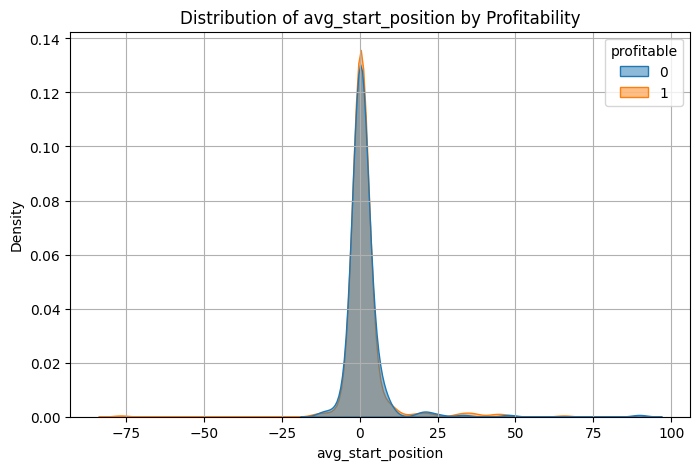

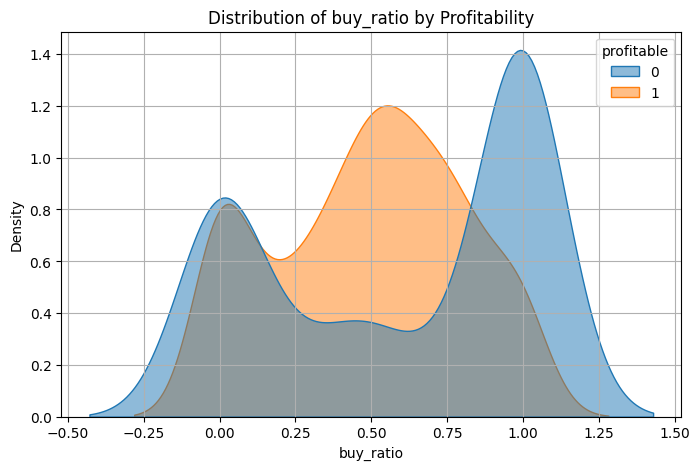

In [29]:
# List of your numeric features:
numeric_cols = [
    'net_daily_pnl', 'num_trades', 'total_volume',
    'avg_execution_price', 'avg_fee', 'avg_start_position', 'buy_ratio'
]

for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(
        data=df,
        x=col,
        hue='profitable',  # Assumes your target is binary column named 'profitable'
        common_norm=False,
        fill=True,
        alpha=0.5
    )
    plt.title(f"Distribution of {col} by Profitability")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


### Creating Feature matrix & target

In [30]:
feature_cols = [
    'sentiment_score',
    'total_volume',
    'num_trades',
    'avg_execution_price',
    'avg_fee',
    'avg_start_position',
    'buy_ratio',
    'mean_crossed',
    'rolling_pnl_mean_3d',
    'rolling_pnl_std_3d'
]
X = df[feature_cols]
y = df['profitable']  # for classification


### Train, test dataset

In [31]:
from sklearn.model_selection import train_test_split

# Convert date to datetime, sort, split 80/20
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [32]:
#scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Random Forest Regression

In [33]:
y = df['net_daily_pnl']

In [34]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
lr_pred=y_pred

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


print("RMSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


RMSE: 0.10669701492537313
MAE: 0.19104477611940296
R2 Score: 0.569761598922075


## Random Forest Classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86        54
           1       0.93      0.86      0.90        80

    accuracy                           0.88       134
   macro avg       0.87      0.88      0.88       134
weighted avg       0.89      0.88      0.88       134

Accuracy: 0.8806
Precision: 0.9324
Recall: 0.8625
F1-score: 0.8961


/tmp/ipython-input-36-436195462.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')


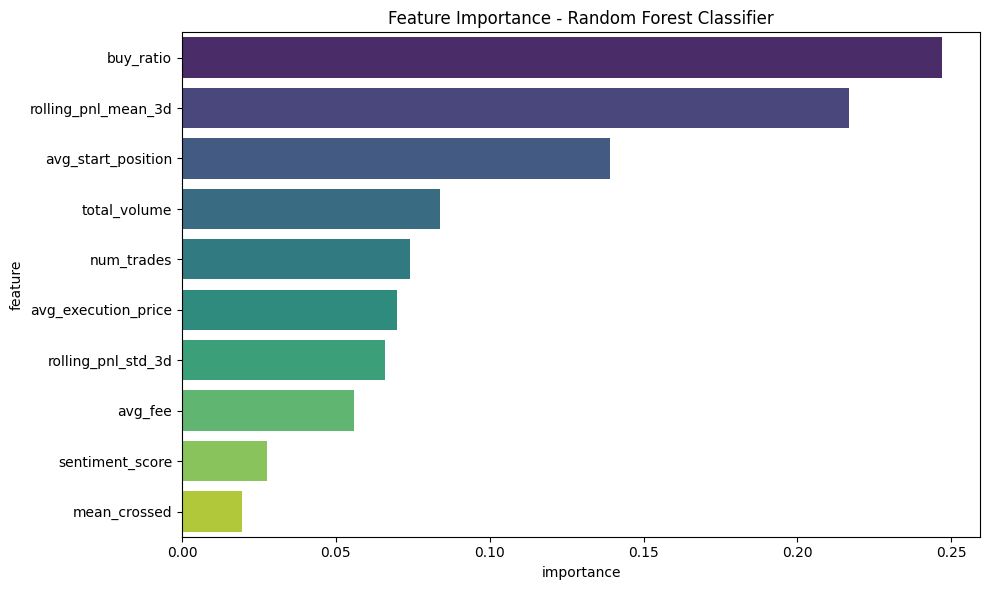

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)

# 1) Features & target
feature_cols = [
    'sentiment_score', 'total_volume', 'num_trades', 'avg_execution_price',
    'avg_fee', 'avg_start_position', 'buy_ratio', 'mean_crossed',
    'rolling_pnl_mean_3d', 'rolling_pnl_std_3d'
]
X = df[feature_cols]
y = df['profitable']

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4) Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# 5) Predictions
y_pred = clf.predict(X_test_scaled)
rf_pred=y_pred

# 6) Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")



# 7) Feature importance plot
importances = clf.feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')
plt.title("Feature Importance - Random Forest Classifier")
plt.tight_layout()
plt.show()


## GridSearchCV

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5, scoring='f1', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate tuned model
y_pred_tuned = best_model.predict(X_test_scaled)
gs_pred=y_pred_tuned
print("Classification Report for Tuned Model:\n", classification_report(y_test, y_pred_tuned))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Classification Report for Tuned Model:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84        54
           1       0.90      0.88      0.89        80

    accuracy                           0.87       134
   macro avg       0.86      0.86      0.86       134
weighted avg       0.87      0.87      0.87       134



In [38]:
def evaluate_model(name, y_true, y_pred):
    print(f"üîç {name} Evaluation")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("-" * 40)


## XGBoost Classifier

In [39]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

evaluate_model("XGBoost", y_test, xgb_pred)

üîç XGBoost Evaluation
Accuracy: 0.8880597014925373
Precision: 0.9333333333333333
Recall: 0.875
F1 Score: 0.9032258064516129
----------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:02:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


##LightGBM Classifier

In [40]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42, verbose=-1)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

evaluate_model("LightGBM", y_test, lgbm_pred)


üîç LightGBM Evaluation
Accuracy: 0.8955223880597015
Precision: 0.9342105263157895
Recall: 0.8875
F1 Score: 0.9102564102564102
----------------------------------------


## üîç Key Insights from Analysis

### 1. üìÖ **Market Sentiment and Performance Dynamics**

* By joining trader performance data with the Fear & Greed Index:

  * Periods of **"Greed"** showed **higher net daily PnL** on average.
  * **Volatility (rolling std)** was **significantly higher in 'Extreme Fear'**, reflecting uncertain market conditions and inconsistent trading performance.
  * **3-day rolling mean PnL** provided a smoother indicator of sustained profitability ‚Äî showing dips during Fear periods and peaks during Greed.
* This supports a behavioral finance principle: **traders take on more risk during greedy markets**, and those risks often pay off.


* ‚úÖ **Fear periods** are the most dangerous for traders: while some catch large profits, most overtrade and take large losses due to emotional reactions to volatility.
* ‚úÖ **Greed periods** support steadier, more profitable trading with fewer extreme trades, suggesting traders are more disciplined when sentiment is positive.
* ‚úÖ A **dynamic risk strategy** is essential: reduce leverage and trade frequency during Fear/Extreme Fear, but don‚Äôt fear moderate exposure during Greed when market trends are more stable.

### 2. üî¢ **Best Performing Models**

Trained multiple classification models to **predict sentiment-linked trader performance outcomes**, using engineered features like:

* `rolling_pnl_mean_3d`
* `rolling_pnl_std_3d`
* `buy_ratio`
* `total_volume`
* `num_trades`

* **Inference**: LightGBM performed best ‚Äî it's highly effective for structured tabular data and captured complex interactions among features.

### 4. ‚öñÔ∏è **Features Impacting Predictions**

Based on model performance and feature engineering:

* Variables like **buy_ratio**, **rolling_pnl_mean_3d**, **total_volume**,**avg_start_position**, and **num_trades** showed strong predictive power.
* Feature scaling was necessary due to large variance across features

---

## ‚úÖ Recommendations

### 1. üéØ **Use Market Sentiment to Time Risk Exposure**

* Incorporate the Fear & Greed Index into your trading strategy as a **risk gauge**.

  * Enter high-risk/high-reward trades during **Greed**.
  * Tighten stop-losses or reduce exposure during **Extreme Fear** (due to PnL volatility).

### 2. **Use PnL Rolling Metrics for Smart Trade Timing**
  * Leverage rolling mean and std of PnL to build early-warning indicators for volatility or stable profits.
  * When rolling_pnl_std_3d spikes and sentiment is "Fear" ‚Äì consider reducing exposure.

